# Parâmetros Gerais para realização do Experimento

In [1]:
numKfolds = 5

idGPU = 0


# Importando bibliotecas para uso com Python

In [2]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00


In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import os
import gc
import copy

import re
import string

import numpy as np
import pandas as pd
from math import ceil

import matplotlib.pyplot as plt

from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import gensim.downloader as api
from gensim.models import KeyedVectors

In [4]:
device = torch.device('cuda:'+str(idGPU) if torch.cuda.is_available() else 'cpu')
write_path = 'model'

# Dataset




In [28]:
dataset = pd.read_csv('./dadosIFG.csv')

df = pd.DataFrame()
df['x'] = dataset['text']
df['y'] = dataset['polarity']

In [29]:
gc.collect()

28

# Visualizando o Atributo Alvo

In [30]:
df["y"].value_counts()

0    270
1    268
2    129
Name: y, dtype: int64

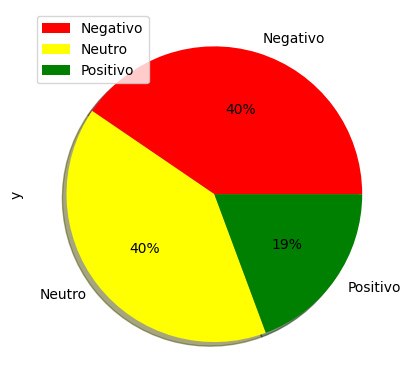

In [31]:
color=['red','yellow', 'green']
explode=[0, 0, 0]
mylabels = ['Negativo', 'Neutro', 'Positivo']

df['y'].value_counts().plot(kind='pie',  autopct='%1.0f%%', labels=mylabels, explode=explode,colors=color, shadow=True)
plt.legend()

# Funções configuradas para o Pré-Processamento de "X"

Função própria para Remover caracteres especiais (acentos e afins)

In [32]:
# Remover caracteres especiais (acentos e afins)

def remove_special_chars(input_text):
    input_text = re.sub(u'[áãâà]', 'a', input_text)
    input_text = re.sub(u'[éèê]', 'e', input_text)
    input_text = re.sub(u'[íì]', 'i', input_text)
    input_text = re.sub(u'[óõôò]', 'o', input_text)
    input_text = re.sub(u'[úùü]', 'u', input_text)
    input_text = re.sub(u'[ç]', 'c', input_text)
    return input_text

Função própria para Remover dígitos

In [33]:
def remove_digits(input_text):
    import re
    return re.sub('\d+', '', input_text)

Função própria para Definir Lista de StopWords

In [34]:
def define_list_stopwords(lg):

  try:
    stopwords_list = stopwords.words(lg)
  except:
    nltk.download('stopwords')
    stopwords_list = stopwords.words(lg)

  return stopwords_list

Função própria para Remover Stopwords

In [35]:
def remove_stopwords(input_text):
    stopwords_list = define_list_stopwords('portuguese')
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

Função própria para Radicalização (Stemming)

In [36]:
def stemming(input_text):
    porter = PorterStemmer()
    words = input_text.split()
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)

Função própria para remover *URL*

In [37]:
def removeURLs(input_text):

  URLless_string = re.sub(r"http\S+", "", str(input_text))
  return (URLless_string)

# Pré-Processamento de "X"

In [38]:
### Função para o pipeline completo do Pré-processamento de "X"

def pipeline_preprocessamento(dfParaProcessar):

  # Lowercase
  dfParaProcessar["x"] = dfParaProcessar["x"].str.lower()

  # Remoção de pontuação e símbolos

  # Tabela de pontuação
  punctuation = string.punctuation
  # Criar tabela de tradução que susbstituirá toda pontuação por um espaço em branco

  trantab = str.maketrans(punctuation, len(punctuation)*' ')
  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: x.translate(trantab))

  # Remover caracteres especiais (acentos e afins) #### SOMENTE NO TFIDF

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_special_chars(x))

  # Remover caracteres especiais com Unidecode

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: unidecode(x))

  # Remover dígitos

  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_digits(x))

  # Remover stopwords

  # dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: remove_stopwords(x))

  # Remover URLs

  dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: removeURLs(x))

  # STEMMING COMENTADO PARA NÃO SER REALIZADO

  ####dfParaProcessar["x"] = dfParaProcessar["x"].apply(lambda x: stemming(x))


  return dfParaProcessar

In [39]:
### realizar o Pré-Processamento Completo

df = pipeline_preprocessamento(df)
df

,x,y
0,pq ngm chuta os fios do moodle do ifg,0
1,ifg não chega nem aos pés,0
2,aí ai gente a ester é artista mais uma a...,2
3,ifg goias ho sr minha filha e funcionária do ...,2
4,que inferno te odeio ifg,0
...,...,...
662,aiii ifg enfia o dedo dentro do cu e cheira ...,0
663,saudades ifg eu no banheiro da escola fazendo...,2
664,eu não aguento mais o ifg,0
665,o ifg esta fazendo de tudo pra acabar com a mi...,0


# Validar as palavras



### Palavras que ocorrem menos de 5 vezes no corpus são retiradas (apenas TDF-IDF, GLOVE e FASTTEXT)



Função própria para identificar palavras com frequência menor que estabelecida

In [40]:
def listarPalavrasMenosFrequentes(xParaProcessar, freqMinimaParaProcessar):
    cnt = xParaProcessar.str.split(expand=True).stack().value_counts()
    lista = []
    for w, c in zip(cnt.index, cnt):
        if(c < freqMinimaParaProcessar):
          lista.append(w)
    return lista


In [41]:
freqMinima = 5
palavrasParaRemover = listarPalavrasMenosFrequentes(df["x"], freqMinima)

Função para remover palavras conforme uma lista definida

In [42]:
def remove_words_in_list(input_text, word_list):

    words = input_text.split()
    clean_words = [word for word in words if (word not in word_list) and len(word) > 1]
    return " ".join(clean_words)

In [43]:
df["x"] = df["x"].apply(lambda x: remove_words_in_list(x, palavrasParaRemover))

# Instanciando o TF-IDF





In [44]:
max_feat = None
tfv = TfidfVectorizer(ngram_range=(1, 3), dtype=np.float32, max_features=max_feat)

In [45]:
def prepararInputTreinamento(xTreinoParaPreparar):

    xTreinoProcessado = tfv.fit_transform(xTreinoParaPreparar)
    return xTreinoProcessado.toarray().astype(np.float16)

In [46]:
def prepararInputTeste(xTesteParaPreparar):

    xTesteProcessado = tfv.transform(xTesteParaPreparar)
    return xTesteProcessado.toarray()

# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    forest = RandomForestClassifier(n_estimators = 200, max_features=0.3, oob_score=True, n_jobs=-1, random_state=1, verbose=2)
    forest.fit(xTreino, yRealTreino)

    pred = forest.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.4s


building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200building tree 76 of 200

building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    7.6s


building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Macro-F1: 0.529177
Micro-F1: 0.574627


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200building tree 39 of 200

building tree 40 of 200
building 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s


building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    8.3s


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


Macro-F1: 0.471425
Micro-F1: 0.544776




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200building tree 15 of 200

building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200building tree 25 of 200

building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.4s


building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200building tree 53 of 200

building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    7.9s


building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Macro-F1: 0.547606
Micro-F1: 0.646617


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s


building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200building tree 76 of 200

building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    8.5s



building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200building tree 166 of 200

building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Macro-F1: 0.429327
Micro-F1: 0.481203


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.3s


building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    5.2s


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200building tree 163 of 200

building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished


Macro-F1: 0.475930
Micro-F1: 0.563910





Média da Macro-F1: 0.562226
Média da Micro-F1: 0.490693
Desvio padrão da Macro-F1: 0.042603


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


# Multinomial Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

numKfolds = 5
micros = []
macros = []

scaler = MinMaxScaler()

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    xTreino = scaler.fit_transform(xTreino)
    xTeste = scaler.transform(xTeste)

    multinomialNB = MultinomialNB()
    multinomialNB.fit(xTreino, yRealTreino)

    pred = multinomialNB.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

Macro-F1: 0.496976
Micro-F1: 0.559701


Macro-F1: 0.466344
Micro-F1: 0.514925


Macro-F1: 0.508341
Micro-F1: 0.601504


Macro-F1: 0.519611
Micro-F1: 0.571429


Macro-F1: 0.559110
Micro-F1: 0.593985





Média da Macro-F1: 0.568309
Média da Micro-F1: 0.510076
Desvio padrão da Macro-F1: 0.030273


# KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(xTreino, yRealTreino)

    pred = knn.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

Macro-F1: 0.471047
Micro-F1: 0.582090


Macro-F1: 0.361488
Micro-F1: 0.455224


Macro-F1: 0.433896
Micro-F1: 0.563910


Macro-F1: 0.406238
Micro-F1: 0.533835


Macro-F1: 0.393474
Micro-F1: 0.503759





Média da Macro-F1: 0.527763
Média da Micro-F1: 0.413229
Desvio padrão da Macro-F1: 0.037112


# SVM

In [50]:
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier

numKfolds = 5
micros = []
macros = []

kf = KFold(n_splits=numKfolds, shuffle=True, random_state=0)

for train_index, test_index in kf.split(df["x"]):
    xTreino, xTeste = df["x"].iloc[train_index], df["x"].iloc[test_index]
    yRealTreino, yRealTeste = df["y"].iloc[train_index], df["y"].iloc[test_index]

    xTreino = prepararInputTreinamento(xTreino)
    xTeste = prepararInputTeste(xTeste)

    svm = LinearSVC(C=1)
    svm.fit(xTreino, yRealTreino)

    pred = svm.predict(xTeste)

    print ("Macro-F1: %f" % f1_score(yRealTeste, pred, average='macro'))
    macros.append(f1_score(yRealTeste, pred, average='macro'))
    print ("Micro-F1: %f" % f1_score(yRealTeste, pred, average='micro'))
    micros.append(f1_score(yRealTeste, pred, average='micro'))
    print('\n')


macro_f1 = np.mean(micros)
micro_f1 = np.mean(macros)
std_f1 = np.std(macros)

print('\n\n')
print(f'Média da Macro-F1: {macro_f1:.6f}')
print(f'Média da Micro-F1: {micro_f1:.6f}')
print(f'Desvio padrão da Macro-F1: {std_f1:.6f}')

Macro-F1: 0.526493
Micro-F1: 0.582090


Macro-F1: 0.495601
Micro-F1: 0.507463


Macro-F1: 0.571203
Micro-F1: 0.646617


Macro-F1: 0.535213
Micro-F1: 0.578947


Macro-F1: 0.608220
Micro-F1: 0.631579





Média da Macro-F1: 0.589339
Média da Micro-F1: 0.547346
Desvio padrão da Macro-F1: 0.038819
